# The Project
This notebook presents my approach to competing in the ["I’m Something of a Painter Myself"](https://www.kaggle.com/competitions/gan-getting-started) competition hosted on Kaggle.

For this project, I have opted to use CycleGAN instead of the Deep Convolutional Generative Adversarial Network (DCGAN) or regular GAN we studied in class. This decision is driven by the specific needs of the competition, which involves transforming photographs to mimic the unique style of Monet's paintings. Unlike DCGAN or traditional GANs, CycleGAN is specially designed for image-to-image translation tasks in an unpaired setting, making it particularly suitable for this style transfer challenge without needing one-to-one corresponding images between the source and target domains.

# Implementation
**The implementation of the CycleGAN used in this notebook was adopted directly from the Kaggle tutorial page on implementing a CycleGAN for this competition.**

For this project, my focus will be on innovating within the provided CycleGAN framework by altering the discriminator and generator networks. The objective is to refine these models so they produce more convincing Monet-style images, capable of achieving high scores based on the Memorization-informed Fréchet Inception Distance (MiFID), which assesses the quality and originality of the generated images.

## Main Task
Furthermore, I implemented and compared two different generator architectures, Generator_A and Generator_B, as part of a CycleGAN-based image-to-image translation task. Both models follow a U-Net-style encoder–decoder architecture that learns to translate a 256×256 RGB image from one domain (real photos) into another domain (Monet-style paintings).

### Housekeeping
Load the necessary packages and mount Google drive here.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import pandas as pd
import os, time
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, LeakyReLU, Dropout
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.layers import Input, Conv2D, LeakyReLU, ZeroPadding2D, Lambda
!pip install matplotlib pillow
import matplotlib.pyplot as plt
from PIL import Image

Mounted at /content/drive


In [3]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

Number of replicas: 1


Download the dataset from Kaggle

In [4]:
#Download Kaggle dataset
from google.colab import files, drive
!pip install Kaggle #install kaggle API

#uplaod your Kaggle API key
# files.upload()

#Kaggle API key
!mkdir -p ~/.kaggle
# !mv kaggle.json ~/.kaggle
!cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle competitions download -c gan-getting-started

 70% 256M/367M [00:00<00:00, 1.33GB/s]
100% 367M/367M [00:00<00:00, 1.34GB/s]


In [6]:
!mkdir -p 'data'
!unzip -o gan-getting-started.zip -d '/content/data' > /dev/null

# EDA
Let's take a look at the data. Here's the structure of the .tfrec files.

In [7]:
for raw_record in tf.data.TFRecordDataset(["/content/data/monet_tfrec/monet00-60.tfrec"]).take(1):
    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())
    print(example)

features {
  feature {
    key: "target"
    value {
      bytes_list {
        value: "monet"
      }
    }
  }
  feature {
    key: "image"
    value {
      bytes_list {
        value: "\377\330\377\340\000\020JFIF\000\001\001\001\001,\001,\000\000\377\333\000C\000\002\001\001\001\001\001\002\001\001\001\002\002\002\002\002\004\003\002\002\002\002\005\004\004\003\004\006\005\006\006\006\005\006\006\006\007\t\010\006\007\t\007\006\006\010\013\010\t\n\n\n\n\n\006\010\013\014\013\n\014\t\n\n\n\377\333\000C\001\002\002\002\002\002\002\005\003\003\005\n\007\006\007\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\377\300\000\021\010\001\000\001\000\003\001\021\000\002\021\001\003\021\001\377\304\000\036\000\000\002\002\003\001\001\001\001\000\000\000\000\000\000\000\000\006\007\004\005\003\010\t\002\000\n\001\377\304\000K\020\000\002\001\002\004\003\005\005\004\t\003\001\007\001\t\000\003\004\005\006\023\000\002\007#\0243C\010\022\025Sc\

Display a few of the Monet images. This is our target domain.

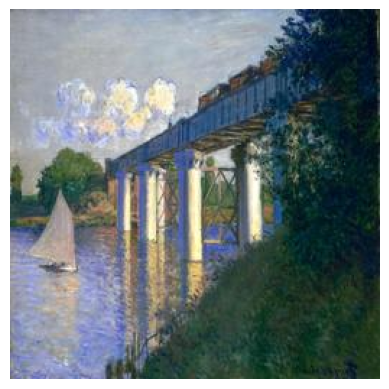

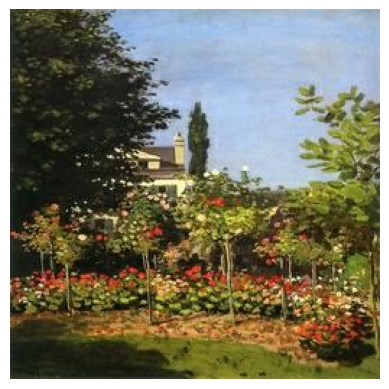

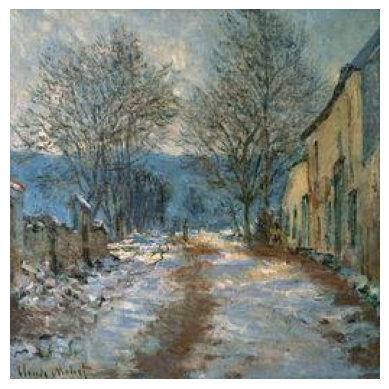

In [8]:
monet_dir = "/content/data/monet_jpg/"
monet_paths = os.listdir(monet_dir)
monet_full_paths = [monet_dir + path for path in monet_paths]
for i in range(3):
  image = Image.open(monet_dir + monet_paths[i])
  plt.imshow(image)
  plt.axis('off')
  plt.show()

Display a few of the photos that we will transfer the Monet style to and generate new images. This is our source domain.

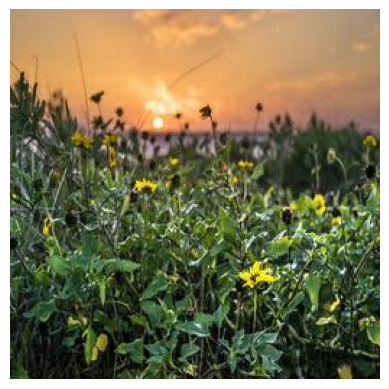

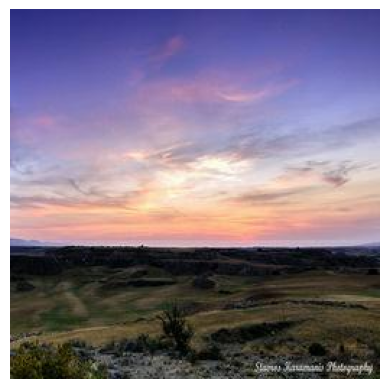

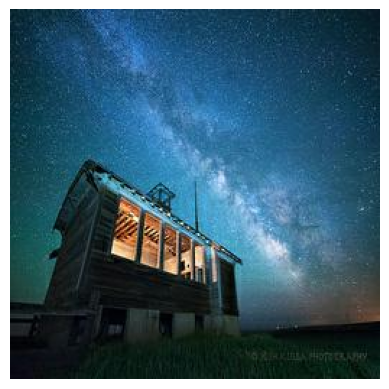

In [9]:
photo_dir = "/content/data/photo_jpg/"
photo_paths = os.listdir(photo_dir)

for i in range(3):
  image = Image.open(photo_dir + photo_paths[i])
  plt.imshow(image)
  plt.axis('off')
  plt.show()

Let's see how many images we're dealing with.

In [10]:
monet_files = len([file for file in monet_paths])
print(f"We have {monet_files} Monet images.")

photo_files = len([file for file in photo_paths])
print(f"We have {photo_files} photo images.")

We have 300 Monet images.
We have 7038 photo images.


# Model Architecture
We implement the CycleGAN by:


1.   Constructing the generator
2.   Constructing the discriminator
3.   Setup of CycleGAN loss functions
4.   Training the CycleGAN
5.   Evaluation and Results



## Constructing the Generator
Here's the general architecture of the generator:
*   Input layer: Takes in photographs from the source domain
*   Downsampling layer(s): Reduces spatial dimensions and capture latent features
*   Upsampling layers: Increases spatial dimensions to transform latent features into the traget domain style.
*   Output layer: Produces an image in the target domain

Before the generator is set up, we need to define the downsampling and upsampling layers ad set up normalization:




In [11]:
# This normalization function normalizes each rgb channel for each images, individually.
# Normalizing in this way helps models focus on spatial structure/style patterns rather than briteness
# or contrast. So, spatial structures are maintained while comparing across intances
# but image constrast and brightness are not.

def instance_normalization(input_tensor):
    epsilon = 1e-5
    mean, variance = tf.nn.moments(input_tensor, axes=[1, 2], keepdims=True)
    return (input_tensor - mean) / tf.sqrt(variance + epsilon)

In [12]:
output_channels = 3

def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(layers.Lambda(instance_normalization))

    result.add(layers.LeakyReLU())

    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(layers.Lambda(instance_normalization))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

### Genertator Setup
### ** ***This is the portion of the code that I altered for the purposes of this assignment. I implement two unique generators and disciminators to examine how design differences affect the output.*** **

In [13]:
def Generator_A():
    inputs = layers.Input(shape=[256,256,3])

    down_stack = [
        downsample(64, 4, apply_instancenorm=False),
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4),
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),
        upsample(256, 4),
        upsample(128, 4),
        upsample(64, 4),
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(output_channels, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh')

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

In [14]:
def Generator_B():
    inputs = layers.Input(shape=[256,256,3])

    down_stack = [
        downsample(32, 4, apply_instancenorm=False),
        downsample(64, 4),
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4),
        downsample(1024, 4),
        downsample(1024, 4),
        downsample(1024, 4),
    ]

    up_stack = [
        upsample(1024, 4, apply_dropout=True),
        upsample(1024, 4, apply_dropout=True),
        upsample(1024, 4, apply_dropout=True),
        upsample(512, 4),
        upsample(256, 4),
        upsample(128, 4),
        upsample(64, 4),
        upsample(32, 4),
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(output_channels, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh')

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

## Constructing the Discriminator
** ***This is the portion of the code that I altered for the purposes of this assignment.*** **

Here's the general architecture of the disciminator:
*   Input layer: Takes in images that are either real or generated
*   Downsampling layer(s): Reduces spatial dimensions and captures latent features of the image
*   Output layer: Gives a 2D image with pixel values corresponding to classification of the input image. Higher pixel values indicate real, while lower values indicate a fake image

In [15]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)
    down4 = downsample(512, 4)(down3) # (bs, 16, 16, 512)

    zero_pad1 = layers.ZeroPadding2D()(down4)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1)

    norm1 = Lambda(instance_normalization)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2)

    return tf.keras.Model(inputs=inp, outputs=last)

In [16]:
# with strategy.scope():
#     monet_generator = Generator() # transforms photos to Monet-esque paintings
#     photo_generator = Generator() # transforms Monet paintings to be more like photos

#     monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
#     photo_discriminator = Discriminator() # differentiates real photos and generated photos

Initialize our generator and discriminators.

In [17]:
with strategy.scope():
  monet_generator_A = Generator_A() # transforms photos to Monet-esque paintings
  photo_generator_A = Generator_A() # transforms Monet paintings to be more like photos
  monet_discriminator_A = Discriminator() # differentiates real Monet paintings and generated Monet paintings
  photo_discriminator_A = Discriminator() # differentiates real photos and generated photos

  monet_generator_B = Generator_B()
  photo_generator_B = Generator_B()
  monet_discriminator_B = Discriminator()
  photo_discriminator_B = Discriminator()


In [18]:
# photo_ds = load_dataset(photo_paths, photo_dir)

# to_monet = monet_generator(example_photo)

# plt.subplot(1, 2, 1)
# plt.title("Original Photo")
# plt.imshow(example_photo[0] * 0.5 + 0.5)

# plt.subplot(1, 2, 2)
# plt.title("Monet-esque Photo")
# plt.imshow(to_monet[0] * 0.5 + 0.5)
# plt.show()

# Construct the CycleGan

In [19]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle

    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn

    def train_step(self, batch_data):
        real_monet, real_photo = batch_data

        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))

        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

## Define Loss Functions
Discriminator loss:

In [20]:
# Conpare real images to matrix of 1s and fake image to a matrix of 0s. Perfect discriminator will output 1s for real images and 0s for fakes.
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5

Generator loss:

In [21]:
# Perfect generator will influence the discrimator to output 1s so we compare the generated image to a matrix of 1s to measure its loss.
with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

Cycle consistency loss:

In [22]:
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

Identity loss:

In [23]:
# This compares an image with its generator. For example, if we feed a photo to the photo generator,
# we expect the generator to generate the same image, therefore, we compare the input to the generator
# with the output of the generator.
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

# Train the CycleGan

In [24]:
with strategy.scope():
    monet_generator_optimizer_A = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer_A  = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    monet_discriminator_optimizer_A = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer_A = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_generator_optimizer_B = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer_B  = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    monet_discriminator_optimizer_B = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer_B = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

Now we need to train both CycleGAN sequentially

In [25]:
with strategy.scope():
    cycle_gan_model_A = CycleGan(
        monet_generator=monet_generator_A,
        photo_generator=photo_generator_A,
        monet_discriminator=monet_discriminator_A,
        photo_discriminator=photo_discriminator_A
    )

    cycle_gan_model_A.compile(
        m_gen_optimizer=monet_generator_optimizer_A,
        p_gen_optimizer=photo_generator_optimizer_A,
        m_disc_optimizer=monet_discriminator_optimizer_A,
        p_disc_optimizer=photo_discriminator_optimizer_A,
        gen_loss_fn=generator_loss,
        disc_loss_fn=discriminator_loss,
        cycle_loss_fn=calc_cycle_loss,
        identity_loss_fn=identity_loss
    )

    cycle_gan_model_B = CycleGan(
        monet_generator=monet_generator_B,
        photo_generator=photo_generator_B,
        monet_discriminator=monet_discriminator_B,
        photo_discriminator=photo_discriminator_B
    )

    cycle_gan_model_B.compile(
        m_gen_optimizer=monet_generator_optimizer_B,
        p_gen_optimizer=photo_generator_optimizer_B,
        m_disc_optimizer=monet_discriminator_optimizer_B,
        p_disc_optimizer=photo_discriminator_optimizer_B,
        gen_loss_fn=generator_loss,
        disc_loss_fn=discriminator_loss,
        cycle_loss_fn=calc_cycle_loss,
        identity_loss_fn=identity_loss
    )

### Load the tfrec data

In [26]:
MONET_FILENAMES = tf.io.gfile.glob(str('/content/data' + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str('/content/data' + '/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


In [27]:

IMAGE_SIZE = [256, 256]
AUTOTUNE = tf.data.experimental.AUTOTUNE

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(1)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1)

In [28]:


with open('/content/data/photo_jpg/00068bc07f.jpg', 'rb') as f:
    print(f.read(100))  # Read first 100 bytes for verification
monet_ds

b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x08\x06\x06\x07\x06\x05\x08\x07\x07\x07\t\t\x08\n\x0c\x14\r\x0c\x0b\x0b\x0c\x19\x12\x13\x0f\x14\x1d\x1a\x1f\x1e\x1d\x1a\x1c\x1c $.\' ",#\x1c\x1c(7),01444\x1f\'9=82<.342\xff\xdb\x00C\x01\t\t\t\x0c\x0b\x0c'


<_BatchDataset element_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)>

In [29]:
# LOad the tf record data.

In [30]:
time_A_start = time.time()
cycle_gan_model_A.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=25
)

time_A = time.time() - time_A_start

Epoch 1/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 40s 22ms/step - monet_disc_loss: 0.7055 - monet_gen_loss: 5.6882 - photo_disc_loss: 0.7024 - photo_gen_loss: 5.7132
Epoch 2/25
  7/300 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - monet_disc_loss: 0.7902 - monet_gen_loss: 3.8842 - photo_disc_loss: 0.7881 - photo_gen_loss: 3.8119

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


300/300 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - monet_disc_loss: 0.6436 - monet_gen_loss: 3.7734 - photo_disc_loss: 0.6476 - photo_gen_loss: 3.7483
Epoch 3/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - monet_disc_loss: 0.6289 - monet_gen_loss: 3.5460 - photo_disc_loss: 0.6316 - photo_gen_loss: 3.5379
Epoch 4/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - monet_disc_loss: 0.6166 - monet_gen_loss: 3.4421 - photo_disc_loss: 0.6216 - photo_gen_loss: 3.4267
Epoch 5/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - monet_disc_loss: 0.6095 - monet_gen_loss: 3.3400 - photo_disc_loss: 0.6144 - photo_gen_loss: 3.3279
Epoch 6/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - monet_disc_loss: 0.6036 - monet_gen_loss: 3.2537 - photo_disc_loss: 0.6076 - photo_gen_loss: 3.2427
Epoch 7/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - monet_disc_loss: 0.6018 - monet_gen_loss: 3.2099 - photo_disc_loss: 0.6004 - photo_gen_loss: 3.2178
Epoch 8/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - monet_disc_loss: 0.6038 - 

In [31]:
time_B_start = time.time()

cycle_gan_model_B.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=25
)

time_B = time.time() - time_B_start

Epoch 1/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 84s 75ms/step - monet_disc_loss: 0.7157 - monet_gen_loss: 6.0069 - photo_disc_loss: 0.7123 - photo_gen_loss: 6.0470
Epoch 2/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 22s 75ms/step - monet_disc_loss: 0.6475 - monet_gen_loss: 4.2349 - photo_disc_loss: 0.6655 - photo_gen_loss: 4.1207
Epoch 3/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 22s 75ms/step - monet_disc_loss: 0.6459 - monet_gen_loss: 3.8212 - photo_disc_loss: 0.6603 - photo_gen_loss: 3.7464
Epoch 4/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 22s 75ms/step - monet_disc_loss: 0.6412 - monet_gen_loss: 3.7041 - photo_disc_loss: 0.6566 - photo_gen_loss: 3.6364
Epoch 5/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 22s 75ms/step - monet_disc_loss: 0.6379 - monet_gen_loss: 3.6069 - photo_disc_loss: 0.6518 - photo_gen_loss: 3.5542
Epoch 6/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 22s 74ms/step - monet_disc_loss: 0.6416 - monet_gen_loss: 3.4943 - photo_disc_loss: 0.6439 - photo_gen_loss: 3.4856
Epoch 7/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 22s 74ms/step - monet_di

## Visualize the Monet-style generated photos
Vizualize our two CycleGANs side by side

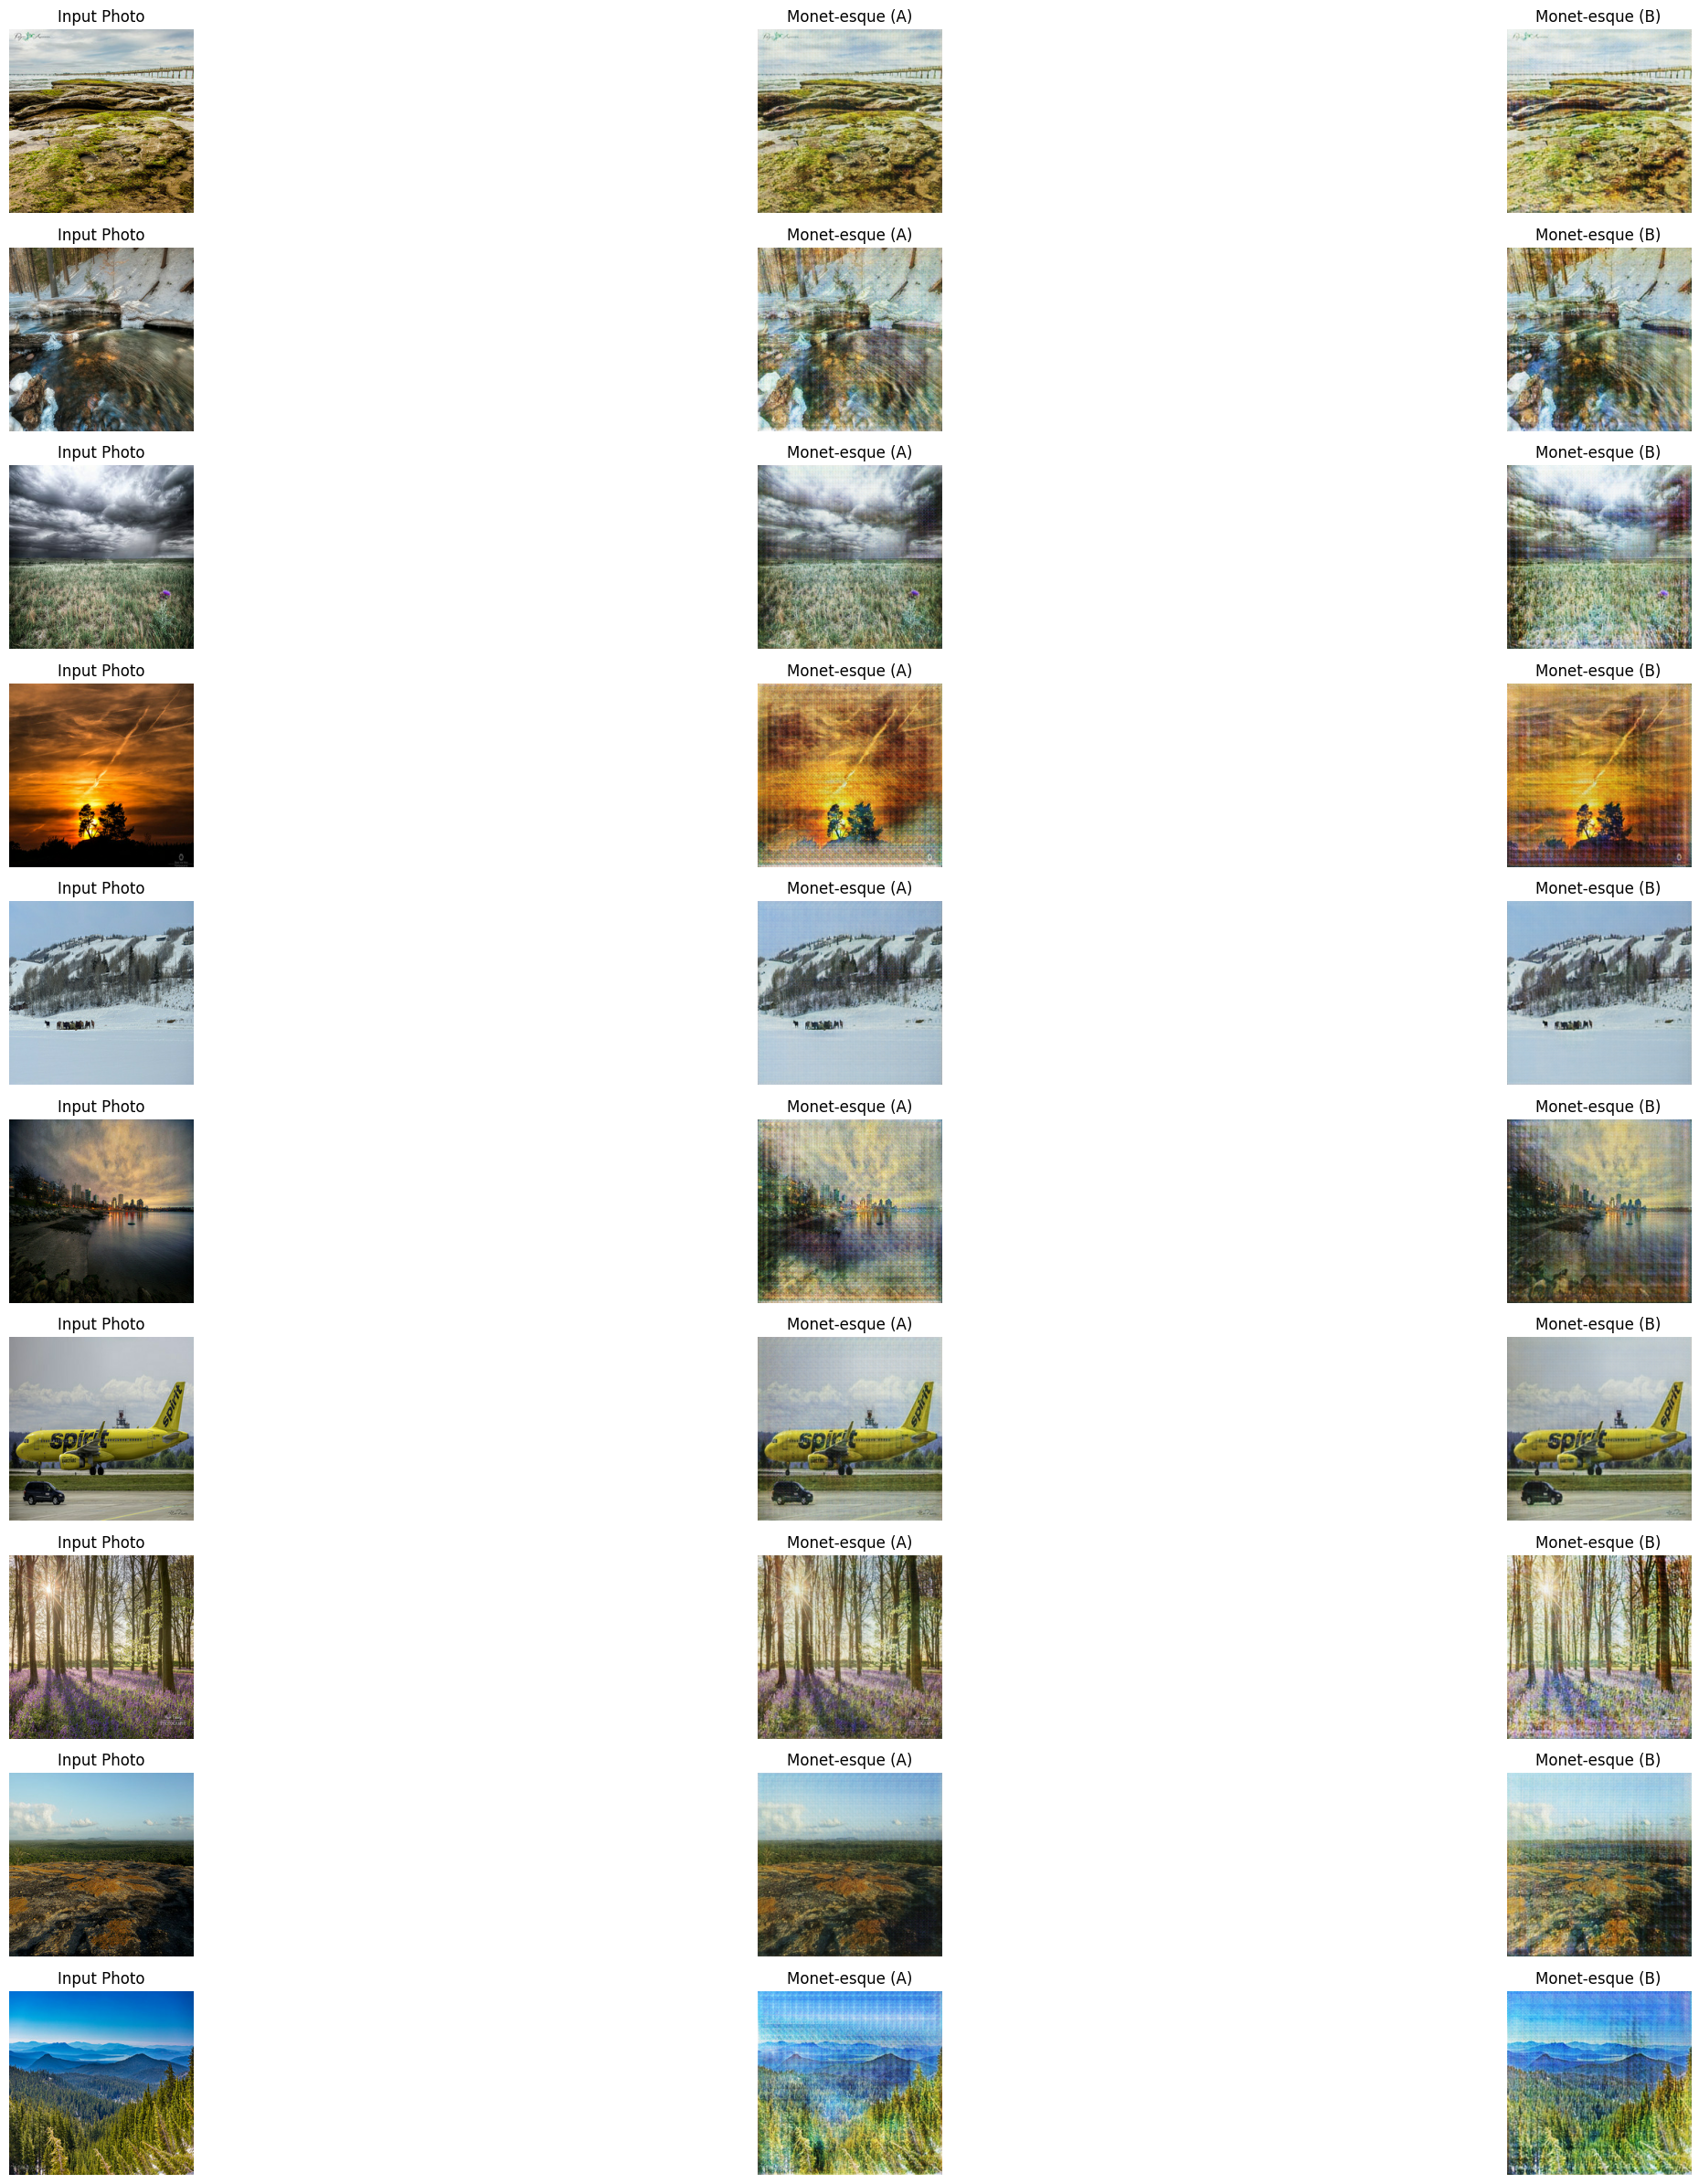

In [35]:
_, ax = plt.subplots(10, 3, figsize=(30, 24))

for i, img in enumerate(photo_ds.take(10)):
    pred_A = cycle_gan_model_A.m_gen(img, training=False)[0].numpy()
    pred_B = cycle_gan_model_B.m_gen(img, training=False)[0].numpy()

    img_np = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)
    pred_A = (pred_A * 127.5 + 127.5).astype(np.uint8)
    pred_B = (pred_B * 127.5 + 127.5).astype(np.uint8)

    ax[i, 0].imshow(img_np)
    ax[i, 1].imshow(pred_A)
    ax[i, 2].imshow(pred_B)

    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque (A)")
    ax[i, 2].set_title("Monet-esque (B)")

    for j in range(3):
        ax[i, j].axis("off")

plt.tight_layout()
plt.show()


## Kaggle Submission File

In [ ]:
import os
import PIL

os.makedirs('/content/images_A', exist_ok=True)
os.makedirs('/content/images_B', exist_ok=True)

for i, img in enumerate(photo_ds.take(1000), 1):
    pred_A = cycle_gan_model_A.m_gen(img, training=False)[0].numpy()
    pred_B = cycle_gan_model_B.m_gen(img, training=False)[0].numpy()

    pred_A = (pred_A * 127.5 + 127.5).astype(np.uint8)
    pred_B = (pred_B * 127.5 + 127.5).astype(np.uint8)

    PIL.Image.fromarray(pred_A).save(f"/content/images_A/{i}.jpg")
    PIL.Image.fromarray(pred_B).save(f"/content/images_B/{i}.jpg")

In [ ]:
import shutil

shutil.make_archive("/content/images_A", 'zip', "/content/images_A")
shutil.make_archive("/content/images_B", 'zip', "/content/images_B")

files.download("/content/images_A.zip")
files.download("/content/images_B.zip")


# Results and Discussion
In this project, I implemented and compared two different generator architectures, Generator_A and Generator_B, as part of a CycleGAN-based image-to-image translation task. Both models follow a U-Net-style encoder–decoder architecture that learns to translate a 256×256 RGB image from real photo into Monet-style images.

---

## Motivation

The generator plays a critical role in GAN performance. It directly influences:
- Image quality
- Fidelity to the target domain
- Training stability

By designing and evaluating multiple architectures, I can assess:
- How model depth, filter size, and feature resolution affect results
- Which design choices generalize better
- Whether increased complexity improves performance or leads to diminishing returns

## Results
The performance of the GAN is highly subjective. However, I believe there are some objective insights one can distil from the models' output:


1.   The CycleGAN works better on a subset of photo image types. In my opinion, both Generator_A and Generator_B work better with input images with long edges and high contrast.
2.   The more complex generator, Generator_B performs better in general. This generator is more complex due to having deeper, more numerous layers.
3.   Neither GAN model produced particularly convincing Monet-style translations. In many cases, the output images appear to have a geometric, filter-like overlay that stands out as artificial and not consistent with painterly textures. This recurring pattern may reflect a structural motif the model identified as characteristic of the Monet style, though it fails to capture the subtlety and fluidity of real brushwork.

